In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb 

# Предподготовка данных

In [6]:
train_data = pd.read_csv("train.csv")
train_data

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15709511.0,Ch'ang,754.0,Spain,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Genovese,579.0,France,Female,28.0,1.0,0.00,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Yeh,744.0,France,Female,56.0,5.0,0.00,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Nwachinemelu,697.0,France,Male,29.0,2.0,0.00,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Hs?eh,628.0,France,Female,22.0,9.0,0.00,2.0,1.0,0.0,49653.39,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15668767.0,Smith,667.0,France,Female,51.0,1.0,0.00,1.0,0.0,0.0,129870.93,1.0
14996,14996,15782231.0,Iweobiegbunam,583.0,Spain,Male,54.0,6.0,0.00,2.0,0.0,1.0,172033.57,1.0
14997,14997,15675501.0,Trevisano,684.0,France,Female,34.0,4.0,0.00,2.0,0.0,1.0,131363.57,0.0
14998,14998,15585595.0,Onyekachi,439.0,Germany,Male,39.0,8.0,107764.75,2.0,1.0,1.0,131710.59,0.0


In [7]:
# Удалим неинформативные столбцы: id, CustomerId, Surname
# Подозрительно, что в колонке CustomerId всего 6276 уникальных значений. При группировке максимальное кол-во с одинаковым CustomerId - 21 человек

In [8]:
# train_data.groupby('CustomerId', as_index=False).\
#             aggregate({'Surname': 'count'}).query('Surname > 1').sort_values('Surname', ascending=False)

In [9]:
X_data = train_data.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
y_data = train_data.Exited

In [10]:
train_data.Exited.value_counts()

Exited
0.0    11942
1.0     3058
Name: count, dtype: int64

In [11]:
# Проверим пропуски
X_data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [12]:
# Заменим Male и Female на "0" и "1"
X_data['Gender'] = X_data['Gender'].apply(lambda x: 0 if x == 'Male' else 1)

# Заменим категориальную переменную Geography
X_data = pd.get_dummies(X_data).astype(int)
X_data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,754,0,40,8,102954,2,1,1,149238,0,0,1
1,579,1,28,1,0,2,1,0,64869,1,0,0
2,744,1,56,5,0,1,1,0,158816,1,0,0
3,697,0,29,2,0,2,1,0,55775,1,0,0
4,628,1,22,9,0,2,1,0,49653,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,667,1,51,1,0,1,0,0,129870,1,0,0
14996,583,0,54,6,0,2,0,1,172033,0,0,1
14997,684,1,34,4,0,2,0,1,131363,1,0,0
14998,439,0,39,8,107764,2,1,1,131710,0,1,0


In [13]:
cor_matrix = X_data.corr(numeric_only=True)
cor_matrix[cor_matrix.abs() > 0.7]
# cor_matrix

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
CreditScore,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tenure,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Balance,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumOfProducts,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
HasCrCard,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
IsActiveMember,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
EstimatedSalary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Geography_France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


# DecisionTreeClassifier

In [15]:
clf = DecisionTreeClassifier(random_state=42)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [17]:
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 20)}

In [18]:
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5, n_jobs=-2)

In [19]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20)})

In [20]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [21]:
best_clf = grid_search_cv_clf.best_estimator_

In [22]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [23]:
best_clf.score(X_train, y_train)

0.9005

In [24]:
best_clf.score(X_test, y_test)

0.9063333333333333

In [148]:
y_pred = best_clf.predict(X_test)
precision_DecisionTree = precision_score(y_test, y_pred)
precision_DecisionTree

0.7886792452830189

In [150]:
recall_DecisionTree = recall_score(y_test, y_pred)
recall_DecisionTree

0.7120954003407155

In [154]:
f1_DecisionTree = f1_score(y_test, y_pred)
f1_DecisionTree

0.7484333034914951

In [27]:
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.00434216, 0.01472754, 0.01472754, ..., 0.96850394, 0.52991453,
       0.04366812])

In [28]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

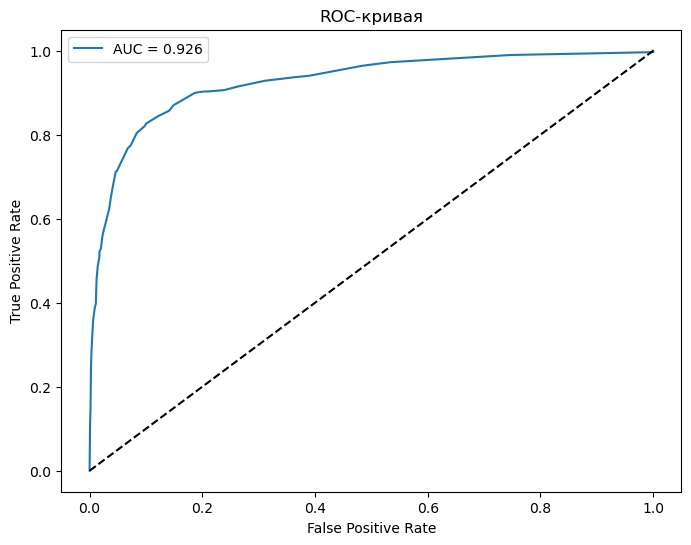

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [30]:
# AUC (Area Under Curve) - площадь под кривой

In [156]:
roc_auc_DecisionTree = roc_auc_score(y_test, y_pred_proba)
roc_auc_DecisionTree

0.9258195422156109

# RandomForestClassifier

In [32]:
rf = RandomForestClassifier(random_state=42)

In [33]:
param_grid = {'n_estimators': [30, 50, 100], 'max_depth': range(1, 10)}

In [34]:
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-2)

In [35]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-2,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': [30, 50, 100]})

In [36]:
grid_search_rf.best_params_

{'max_depth': 9, 'n_estimators': 50}

In [37]:
best_rf = grid_search_rf.best_estimator_

In [38]:
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

In [39]:
accuracy_score(y_test, y_pred_rf)

0.9093333333333333

In [165]:
f1_score(y_test, y_pred_rf)

0.7429111531190926

In [169]:
precision_score(y_test, y_pred_rf)

0.8343949044585988

In [175]:
recall_score(y_test, y_pred_rf)

0.6695059625212947

In [43]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba_rf)

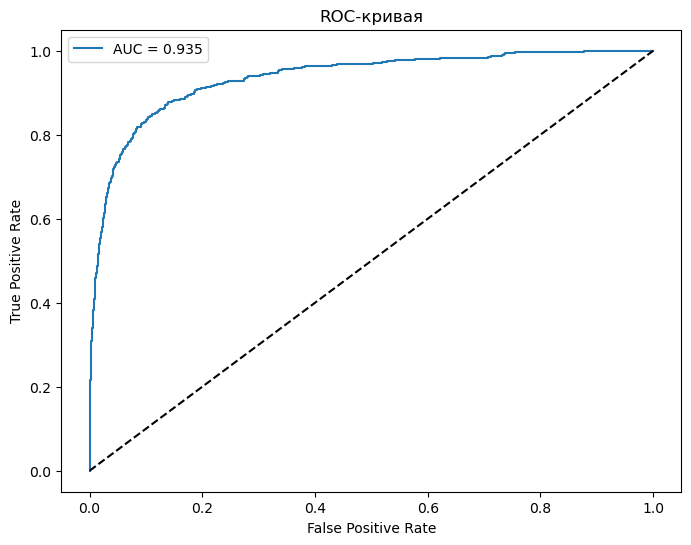

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [45]:
# AUC увеличилась, теперь определим пороговое значеине при оптимизации f1
f1 = 0
for thresh in threshold:
    y_pred_temp = (y_pred_proba_rf >= thresh).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp)
    if f1 < f1_temp:
        f1 = f1_temp
        threshold_opt = thresh

print(f1)
print(threshold_opt)

0.7603725656223539
0.3590716698614368


In [46]:
# Определим предсказанные значения по оптимальному пороговому значению
y_pred_opt = (y_pred_proba_rf >= threshold_opt).astype(int)

In [167]:
f1_RandomForest = f1_score(y_test, y_pred_opt)
f1_RandomForest

0.7603725656223539

In [171]:
precision_RandomForest = precision_score(y_test, y_pred_opt)
precision_RandomForest

0.7558922558922558

In [177]:
recall_RandomForest = recall_score(y_test, y_pred_opt)
recall_RandomForest

0.7649063032367973

In [50]:
accuracy_score(y_test, y_pred_opt)

0.9056666666666666

In [179]:
roc_auc_RandomForest = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_RandomForest

0.934974594597266

# LogisticRegression

In [52]:
# Масштабируем данные
X_scaled_train = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_scaled_train

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
9839,0.221957,1.0,0.392857,0.4,0.713880,0.000000,1.0,1.0,0.113442,0.0,1.0,0.0
9680,0.553699,1.0,0.410714,0.0,0.318697,0.000000,1.0,0.0,0.083421,1.0,0.0,0.0
7093,1.000000,0.0,0.375000,0.8,0.000000,0.333333,1.0,0.0,0.109701,1.0,0.0,0.0
11293,0.357995,0.0,0.464286,0.7,0.000000,0.000000,0.0,1.0,0.107828,1.0,0.0,0.0
820,0.529833,1.0,0.285714,0.4,0.000000,0.333333,1.0,1.0,0.090848,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.682578,0.0,0.250000,0.2,0.000000,0.333333,1.0,0.0,0.040339,1.0,0.0,0.0
13418,0.599045,0.0,0.303571,0.8,0.000000,0.333333,1.0,1.0,0.102633,1.0,0.0,0.0
5390,0.334129,0.0,0.392857,0.2,0.000000,0.333333,1.0,0.0,0.038851,1.0,0.0,0.0
860,0.548926,0.0,0.517857,0.6,0.000000,0.333333,1.0,0.0,0.086704,1.0,0.0,0.0


In [53]:
# То же самое с X_test
X_scaled_test = pd.DataFrame(MinMaxScaler().fit_transform(X_test), columns=X_test.columns, index=X_test.index)

In [54]:
model = LogisticRegression(max_iter=10000, random_state=42, class_weight='balanced')

In [55]:
model.fit(X_scaled_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)

In [56]:
y_pred_log = model.predict(X_scaled_test)

In [57]:
accuracy_score(y_test, y_pred_log)

0.6906666666666667

In [181]:
precision_LogisticReg = precision_score(y_test, y_pred_log)
precision_LogisticReg

0.37777777777777777

In [183]:
recall_LogisticReg = recall_score(y_test, y_pred_log)
recall_LogisticReg

0.8977853492333902

In [185]:
f1_LogisticReg = f1_score(y_test, y_pred_log)
f1_LogisticReg

0.5317860746720484

In [61]:
y_pred_proba_log = model.predict_proba(X_scaled_test)[:, 1]

In [62]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba_log)

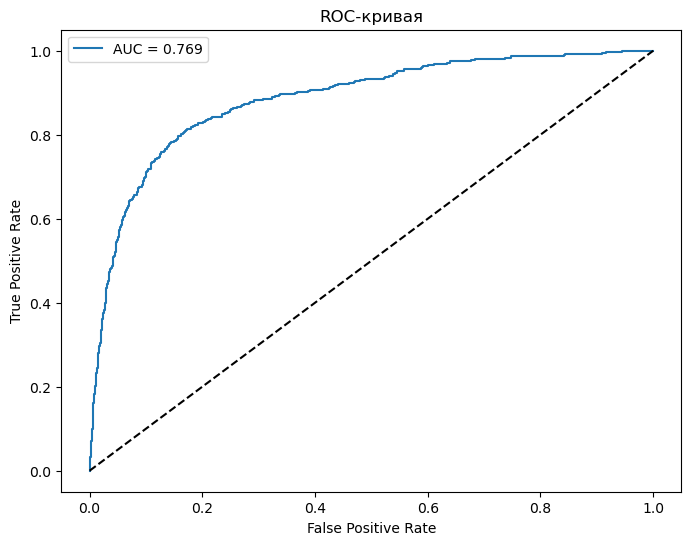

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_log):.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [187]:
roc_auc_LogisticReg = roc_auc_score(y_test, y_pred_log)
roc_auc_LogisticReg

0.7690335780563966

# XGBoost

In [65]:
model_xgb = xgb.XGBClassifier(random_state=42)

In [66]:
parameters = {'n_estimators': [100, 200, 300],
             'max_depth': [3, 5],
             'learning_rate': [0.1],
             'reg_lambda': [0, 1, 2],
             'gamma': [0, 1, 2]}

In [67]:
grid_search_cv_xgb = GridSearchCV(model_xgb, parameters, cv=5, n_jobs=-2)

In [68]:
grid_search_cv_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-2,
             param_grid={'gamma': [0, 1, 2], 'learning_rate': [0.1],
                         'max_depth': [3, 5], 'n_estimators': [100, 200, 300],
                         'reg_lambda': [0, 1, 2]})

In [69]:
grid_search_cv_xgb.best_params_

{'gamma': 2,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_lambda': 1}

In [70]:
best_xgb = grid_search_cv_xgb.best_estimator_

In [71]:
best_xgb.score(X_train, y_train)

0.90525

In [72]:
best_xgb.score(X_test, y_test)

0.9086666666666666

In [191]:
y_pred_xgb = grid_search_cv_xgb.predict(X_test)

In [193]:
precision_xgb = precision_score(y_test, y_pred_xgb)
precision_xgb

0.8161616161616162

In [195]:
recall_xgb = recall_score(y_test, y_pred_xgb)
recall_xgb

0.6882453151618398

In [197]:
f1_xgb = f1_score(y_test, y_pred_xgb)
f1_xgb

0.7467652495378928

In [73]:
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

In [74]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba_xgb)

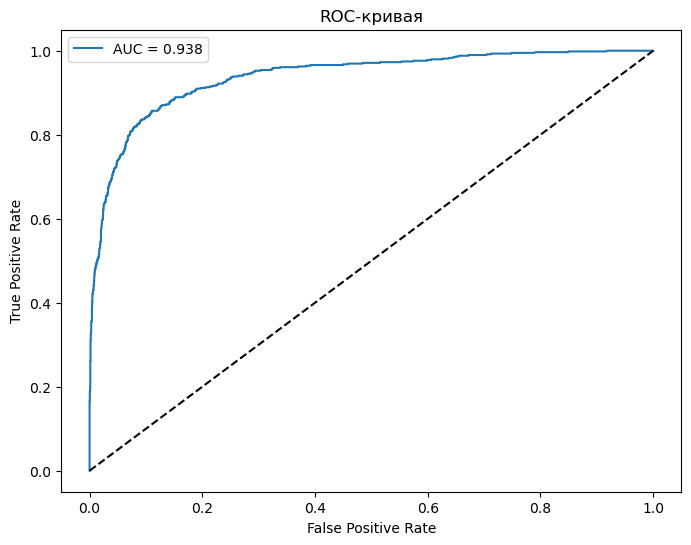

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [199]:
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_xgb

0.9379592087436662

# Итоги расчетов

In [222]:
table_result = pd.DataFrame({'quality_metrics': ['precision', 'recall', 'f1_score', 'roc_auc'],
                            'DecisionTree': [precision_DecisionTree, recall_DecisionTree, f1_DecisionTree, roc_auc_DecisionTree], 
                            'RandomForest': [precision_RandomForest, recall_RandomForest, f1_RandomForest, roc_auc_RandomForest],
                            'LogisticRegression': [precision_LogisticReg, recall_LogisticReg, f1_LogisticReg, roc_auc_LogisticReg],
                            'XGBoost': [precision_xgb, recall_xgb, f1_xgb, roc_auc_xgb]}).round(3)
table_result

,quality_metrics,DecisionTree,RandomForest,LogisticRegression,XGBoost
0,precision,0.789,0.756,0.378,0.816
1,recall,0.712,0.765,0.898,0.688
2,f1_score,0.748,0.760,0.532,0.747
3,roc_auc,0.926,0.935,0.769,0.938


## С точки зрения roc_auc наилучшие результаты показала модель XGBoost.  
## Хотя для данной задачи отрыв  от RandomForest и даже DecisionTree не слишком велик